## House Price Prediction using Linear, Ridge, and Lasso Regression

The solution is divided into the following 8 sections:
1. Data understanding and exploration
2. Data cleaning
3. Exploratory data analysis (EDA)
4. Data preparation
5. Model building and evaluation using Linear, Ridge, and Lasso regression models
6. Model metrics comparison table
7. Coefficient comparison and interpretation
8. Business interpretation

## Variable Definitions and Usage

- **df**: The main DataFrame containing all house sale records and features.
- **X**: Predictor variables (features) used for modeling, created by dropping the target variable 'SalePrice' from df.
- **y**: The target variable, 'SalePrice', which we aim to predict.
- **X_train, X_test, y_train, y_test**: Training and testing splits of the predictors and target, used to train and evaluate models.
- **X_scaled**: Scaled version of X, ensuring all features are on the same scale for regularization.
- **lm**: Linear Regression model object.
- **ridge_best, lasso_best**: Ridge and Lasso regression model objects with optimal alpha values found via cross-validation.
- **y_pred_train, y_pred_test**: Predictions from the Linear Regression model for training and test sets.
- **metrics_df**: DataFrame summarizing R2 and RMSE metrics for all models.
- **betas**: DataFrame containing coefficients from Linear, Ridge, and Lasso models for feature importance comparison.

These variables are used throughout the notebook to process data, build models, and interpret results.

### 1. Data Understanding and Exploration

In this section, I import all the necessary libraries and load the dataset into a pandas DataFrame called `df`. 

I check the initial shape and preview the data to get a sense of the variables, their types, and any immediate issues such as missing values or duplicates. 

In [134]:
# 1. Data Understanding and Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [135]:
# Load the dataset 
df = pd.read_csv('train.csv')  
print("Initial shape:", df.shape)
display(df.head())

Initial shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [136]:
# Check for duplicates and missing values
print("Duplicate rows:", df.duplicated().sum())
df.info()
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int

### 2. Data Cleaning

In this section, I address data quality issues to ensure the dataset is ready for analysis and modeling.  

I start by dropping columns with more than 80% missing values, as they are unlikely to provide useful information.  

I impute missing values for numerical and categorical columns, and remove any duplicate rows.  

I also derive new features such as TotalSF, HouseAge, and RemodAge to enhance the dataset for modeling.  
These steps help convert the data into a clean and analysis-ready format.

In [137]:
# Drop columns with more than 80% missing values
missing_percent = df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 80].index
df = df.drop(cols_to_drop, axis=1)
print("Dropped columns with >80% missing values:", list(cols_to_drop))

# Impute missing LotFrontage with median (numerical)
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

# Drop specific columns with many missing values (if still present)
df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, errors='ignore')  # Safe if already dropped

# Fill remaining categorical NA with 'None'
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('None')

# Derive new features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']  # Total square footage
df['HouseAge'] = df['YrSold'] - df['YearBuilt']                      # Age of the house at sale
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']                   # Years since last remodel

# Check again for missing values after all imputations and feature engineering
print("Remaining missing values:\n", df.isnull().sum().sort_values(ascending=False).head(10))

# Remove duplicate rows if any
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

Dropped columns with >80% missing values: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
Remaining missing values:
 GarageYrBlt     81
MasVnrArea       8
Id               0
Electrical       0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
dtype: int64
Shape after removing duplicates: (1460, 80)


### 3. Exploratory Data Analysis (EDA)

In this section, I explore the data visually and statistically. I plot the distribution of the target variable (`SalePrice`) to understand its spread and look for skewness or outliers.

I also examine the correlation matrix for numeric features to identify which variables are most strongly related to house prices.

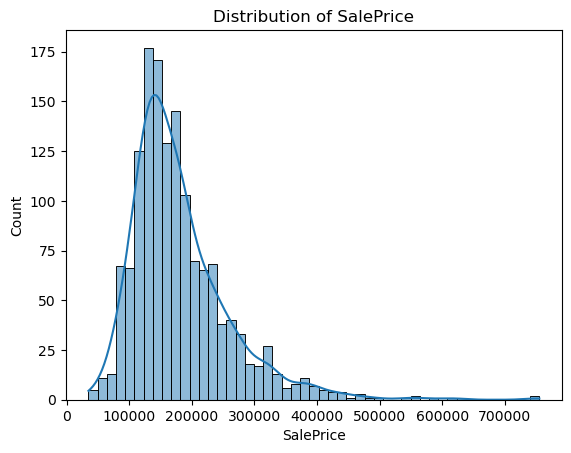

In [138]:

# Visualize target variable 'SalesPrice'
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

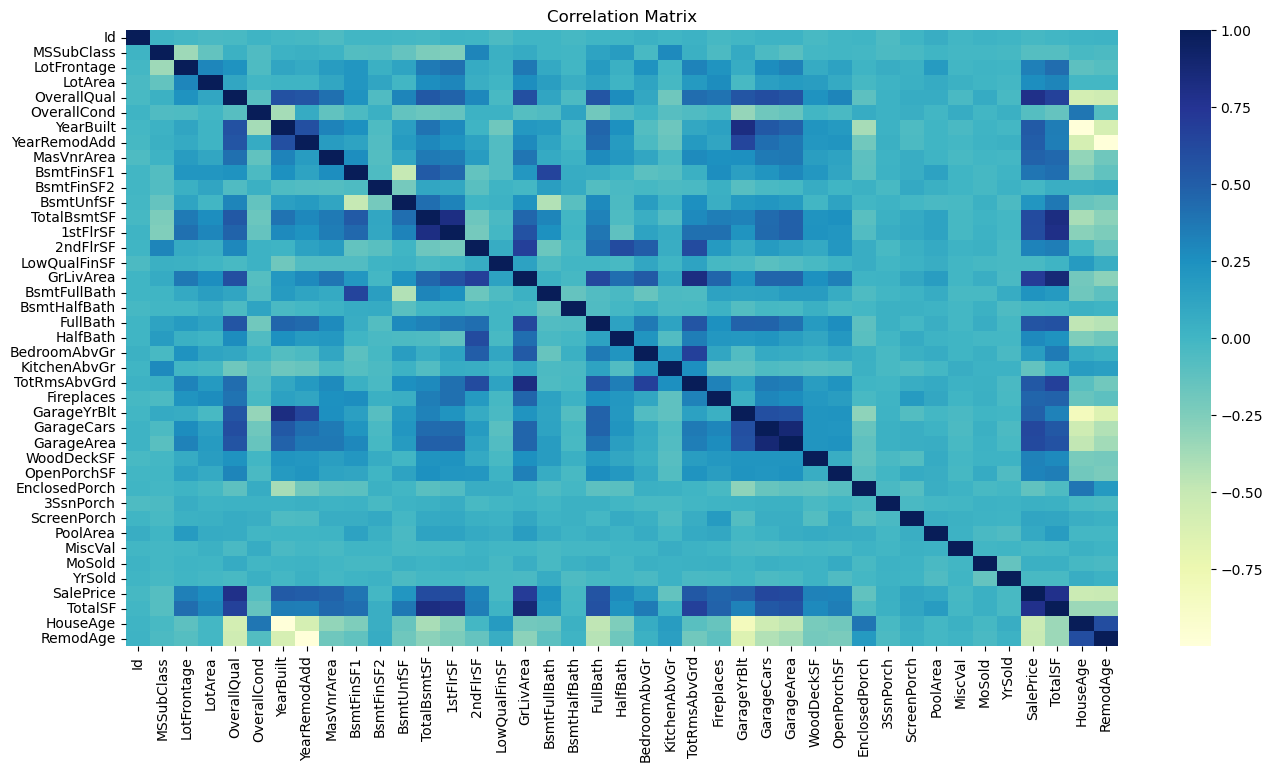

In [139]:
# Correlation matrix for numeric variables
numeric_df = df.select_dtypes(include=[np.number])
cor = numeric_df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(cor, cmap="YlGnBu", annot=False)
plt.title('Correlation Matrix')
plt.show()

### 4. Data Preparation

Here, I prepare the data for modeling.

I separate the predictors (`X`) from the target (`y`), encode categorical variables using one-hot encoding, handle any remaining missing values, and scale the features.

Finally, I split the data into training and testing sets to ensure fair evaluation of my models.

In [140]:
# 4. Data Preparation

# Separate predictors and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Create dummy variables for categorical columns
X = pd.get_dummies(X, drop_first=True)

# Impute any remaining missing values in X with column mean
X = X.fillna(X.mean())


# Double-check for NaNs after scaling and fill with 0 if any remain
if X_scaled.isnull().sum().sum() > 0:
    X_scaled = X_scaled.fillna(0)

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7, random_state=100)

### 5. Model Building and Evaluation

In this section, I build and evaluate three regression models: Linear Regression, Ridge Regression, and Lasso Regression.

I use cross-validation to tune the regularization parameter (alpha) for Ridge and Lasso. 

I then assess model performance using R² and RMSE on both the training and test sets.

In [141]:
# 5. Model Building and Evaluation

# Linear Regression
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

#R2 and RMSE for train and test sets
print('Linear Regression Train R2:', r2_score(y_train, y_pred_train))
print('Linear Regression Test R2:', r2_score(y_test, y_pred_test))
print('Linear Regression Train RMSE:', mean_squared_error(y_train, y_pred_train)**0.5)
print('Linear Regression Test RMSE:', mean_squared_error(y_test, y_pred_test)**0.5)

Linear Regression Train R2: 0.9493090565635154
Linear Regression Test R2: 0.8259526252925733
Linear Regression Train RMSE: 17800.23899697249
Linear Regression Test RMSE: 33470.82645986979


In [142]:
# Ridge Regression (with hyperparameter tuning)

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=1)
ridge_cv.fit(X_train, y_train) #Find best alpha using cross-validation
print('Best Ridge alpha:', ridge_cv.best_params_)
ridge_best = Ridge(alpha=ridge_cv.best_params_['alpha'])
ridge_best.fit(X_train, y_train)
print('Ridge Train R2:', r2_score(y_train, ridge_best.predict(X_train)))
print('Ridge Test R2:', r2_score(y_test, ridge_best.predict(X_test)))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Ridge alpha: {'alpha': 500}
Ridge Train R2: 0.8850969289402495
Ridge Test R2: 0.855438189250192


In [143]:
# Lasso Regression (with hyperparameter tuning)
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=1)
lasso_cv.fit(X_train, y_train) #Find best alpha using cross-validation
print('Best Lasso alpha:', lasso_cv.best_params_) 
lasso_best = Lasso(alpha=lasso_cv.best_params_['alpha'])
lasso_best.fit(X_train, y_train)
print('Lasso Train R2:', r2_score(y_train, lasso_best.predict(X_train)))
print('Lasso Test R2:', r2_score(y_test, lasso_best.predict(X_test)))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Lasso alpha: {'alpha': 1000}
Lasso Train R2: 0.8921794366508309
Lasso Test R2: 0.8401769878914237


In [144]:
# Model metrics comparison table
metrics_df = pd.DataFrame({
    'Model': ['Linear', 'Ridge', 'Lasso'],
    'Train R2': [
        r2_score(y_train, y_pred_train),
        r2_score(y_train, ridge_best.predict(X_train)),
        r2_score(y_train, lasso_best.predict(X_train))
    ],
    'Test R2': [
        r2_score(y_test, y_pred_test),
        r2_score(y_test, ridge_best.predict(X_test)),
        r2_score(y_test, lasso_best.predict(X_test))
    ],
    'Train RMSE': [
        mean_squared_error(y_train, y_pred_train)**0.5,
        mean_squared_error(y_train, ridge_best.predict(X_train))**0.5,
        mean_squared_error(y_train, lasso_best.predict(X_train))**0.5
    ],
    'Test RMSE': [
        mean_squared_error(y_test, y_pred_test)**0.5,
        mean_squared_error(y_test, ridge_best.predict(X_test))**0.5,
        mean_squared_error(y_test, lasso_best.predict(X_test))**0.5
    ]
})
display(metrics_df)

,Model,Train R2,Test R2,Train RMSE,Test RMSE
0,Linear,0.949309,0.825953,17800.238997,33470.826460
1,Ridge,0.885097,0.855438,26799.485999,30504.189299
2,Lasso,0.892179,0.840177,25960.403877,32073.943018


### 7. Coefficient Comparison and Interpretation

In this section, I compare the coefficients from the Linear, Ridge, and Lasso models.

This helps me understand which features are most important for predicting house prices and how regularization affects feature selection and importance.

In [145]:
# 6. Coefficient Comparison and Interpretation

betas = pd.DataFrame(index=X_train.columns)
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge_best.coef_
betas['Lasso'] = lasso_best.coef_

# Show top 20 variables by absolute value of Linear coefficients
print("Top variables by importance (Linear Regression):")
display(betas.reindex(betas['Linear'].abs().sort_values(ascending=False).index).head(20))


Top variables by importance (Linear Regression):


,Linear,Ridge,Lasso
RoofMatl_CompShg,99894.630712,1886.619372,2608.805650
RoofMatl_Tar&Grv,66542.271847,415.280082,0.000000
RoofMatl_WdShngl,52152.027586,5121.550787,5681.774547
RoofMatl_WdShake,43206.480750,587.785238,427.652330
RoofMatl_Membran,22327.371743,760.896074,134.383850
RoofMatl_Metal,20980.059048,198.952944,0.000000
RoofMatl_Roll,19561.317564,348.597482,0.000000
Condition2_PosN,-17215.595377,-6102.254226,-10750.864526
2ndFlrSF,15965.461160,4716.086247,0.000000
GrLivArea,15959.048481,7121.702074,21300.505120


### 8. Business Interpretation

Finally, I translate my technical findings into actionable business insights.

I highlight the most influential features for predicting house prices and explain how regularization can help stakeholders focus on the factors that matter most for maximizing property value.

In [146]:
# Show top 10 features by absolute value for Linear Regression
top_features = betas['Linear'].abs().sort_values(ascending=False).head(10)
print(top_features)

RoofMatl_CompShg    99894.630712
RoofMatl_Tar&Grv    66542.271847
RoofMatl_WdShngl    52152.027586
RoofMatl_WdShake    43206.480750
RoofMatl_Membran    22327.371743
RoofMatl_Metal      20980.059048
RoofMatl_Roll       19561.317564
Condition2_PosN     17215.595377
2ndFlrSF            15965.461160
GrLivArea           15959.048481
Name: Linear, dtype: float64


- The variables with the largest coefficients (absolute value) are the most significant in predicting house prices.
- Ridge and Lasso regularization shrink less important coefficients, with Lasso potentially setting some to zero (feature selection).
- The R2 and RMSE metrics above show how well the models fit the data.
- The optimal lambda (alpha) values for Ridge and Lasso are shown above; these control the strength of regularization.
- Management can use these insights to focus on the most impactful features when making investment decisions.








## Subjective Assignment questions Code Snippets

In [108]:
print('Best Ridge alpha:', ridge_cv.best_params_)
print('Best Lasso alpha:', lasso_cv.best_params_)

Best Ridge alpha: {'alpha': 500}
Best Lasso alpha: {'alpha': 1000}


In [109]:
# 1. Optimal alpha values
print("Optimal Ridge alpha:", ridge_cv.best_params_['alpha'])
print("Optimal Lasso alpha:", lasso_cv.best_params_['alpha'])

# 2. Fit Ridge and Lasso with double the optimal alpha
ridge_double = Ridge(alpha=2 * ridge_cv.best_params_['alpha'])
ridge_double.fit(X_train, y_train)
lasso_double = Lasso(alpha=2 * lasso_cv.best_params_['alpha'])
lasso_double.fit(X_train, y_train)

# 3. Most important predictors after doubling alpha
# For Ridge: top 10 by absolute coefficient
ridge_double_coefs = pd.Series(ridge_double.coef_, index=X_train.columns)
print("\nTop 5 Ridge predictors (double alpha):")
print(ridge_double_coefs.abs().sort_values(ascending=False).head(5))

# For Lasso: non-zero coefficients, sorted by absolute value
lasso_double_coefs = pd.Series(lasso_double.coef_, index=X_train.columns)
important_lasso = lasso_double_coefs[lasso_double_coefs != 0].abs().sort_values(ascending=False)
print("\nTop 5 Lasso predictors (double alpha):")
print(important_lasso.head(5))

Optimal Ridge alpha: 500
Optimal Lasso alpha: 1000

Top 5 Ridge predictors (double alpha):
OverallQual             7113.223661
GrLivArea               6757.685411
Neighborhood_NoRidge    5188.843648
1stFlrSF                4855.019295
Neighborhood_NridgHt    4533.970545
dtype: float64

Top 5 Lasso predictors (double alpha):
GrLivArea               25549.127696
OverallQual             20213.698067
Condition2_PosN          8477.639763
Neighborhood_NridgHt     7409.673862
GarageCars               7316.644603
dtype: float64


In [110]:
# Compare Ridge coefficients before and after doubling alpha
ridge_orig_coefs = pd.Series(ridge_best.coef_, index=X_train.columns)
ridge_double_coefs = pd.Series(ridge_double.coef_, index=X_train.columns)
print("Ridge - Mean absolute coefficient (original alpha):", ridge_orig_coefs.abs().mean())
print("Ridge - Mean absolute coefficient (double alpha):", ridge_double_coefs.abs().mean())

# Compare Lasso coefficients before and after doubling alpha
lasso_orig_coefs = pd.Series(lasso_best.coef_, index=X_train.columns)
lasso_double_coefs = pd.Series(lasso_double.coef_, index=X_train.columns)
print("Lasso - Mean absolute coefficient (original alpha):", lasso_orig_coefs.abs().mean())
print("Lasso - Mean absolute coefficient (double alpha):", lasso_double_coefs.abs().mean())

Ridge - Mean absolute coefficient (original alpha): 1086.0818551326024
Ridge - Mean absolute coefficient (double alpha): 926.6028525307662
Lasso - Mean absolute coefficient (original alpha): 852.0384647322263
Lasso - Mean absolute coefficient (double alpha): 618.7328210942761


In [111]:
# 1. Get the top 5 most important features from the Lasso model
lasso_coefs = pd.Series(lasso_best.coef_, index=X_train.columns)
top5_features = lasso_coefs.abs().sort_values(ascending=False).head(5).index.tolist()
top5_features

['GrLivArea',
 'OverallQual',
 'Condition2_PosN',
 'Neighborhood_NridgHt',
 'Neighborhood_NoRidge']

In [112]:
# 2. Remove these features from X_train and X_test
X_train_new = X_train.drop(columns=top5_features)
X_test_new = X_test.drop(columns=top5_features)

In [113]:
# 3. Retrain the Lasso model on the reduced feature set
lasso_new = Lasso(alpha=lasso_cv.best_params_['alpha'])
lasso_new.fit(X_train_new, y_train)

Lasso(alpha=1000)

In [114]:
# 4. Get the next five most important features
lasso_new_coefs = pd.Series(lasso_new.coef_, index=X_train_new.columns)
next5_features = lasso_new_coefs.abs().sort_values(ascending=False).head(5)
print("The next five most important predictor variables are:")
print(next5_features)

The next five most important predictor variables are:
2ndFlrSF          23264.056489
1stFlrSF          18876.336120
KitchenQual_Gd    10465.724440
KitchenQual_TA    10215.985749
BsmtQual_Gd        9926.060062
dtype: float64
